In [50]:
%reload_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np


from src.preprocessing import Engine
from src.tools.config import CONFIG
from src.tools.visualization import boxplot, grid_plot_same_sensor_all_units, no_grid_plot_raw_sensors, grid_plot_RUL, auto_correlation



## Load

In [51]:
######################################################### Load and Process Data
engine = Engine(CONFIG['train_files'], CONFIG['test_files'])
engine.load_train_data()
engine.load_test_data()
df_train = engine.calculate_rul()
df_test = engine.data_test

## raw sensors

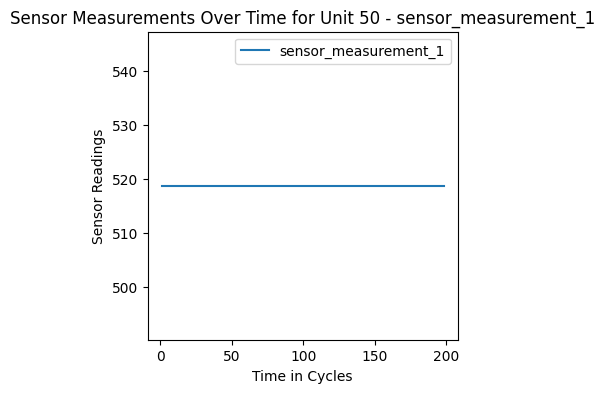

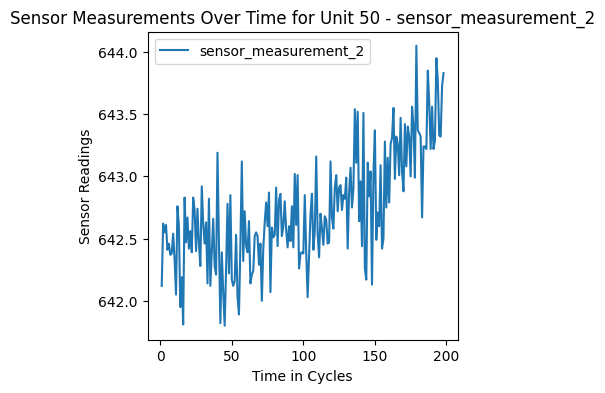

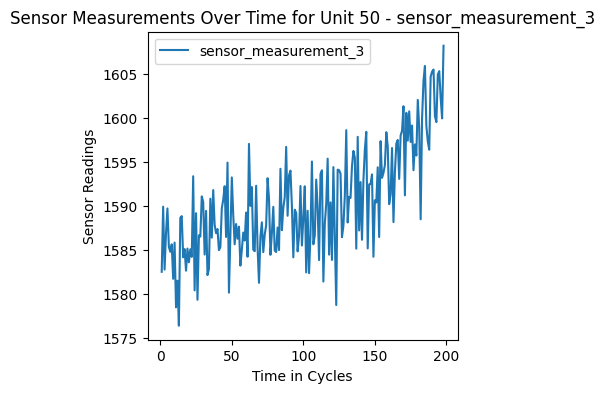

In [52]:
for sensor in [f"sensor_measurement_{x}" for x in range(1, 4)]:  # Adjust as needed
    no_grid_plot_raw_sensors_fig = no_grid_plot_raw_sensors(df_train,sensor, unit_id = 50)
    no_grid_plot_raw_sensors_fig.show()


## one sensor data per all units

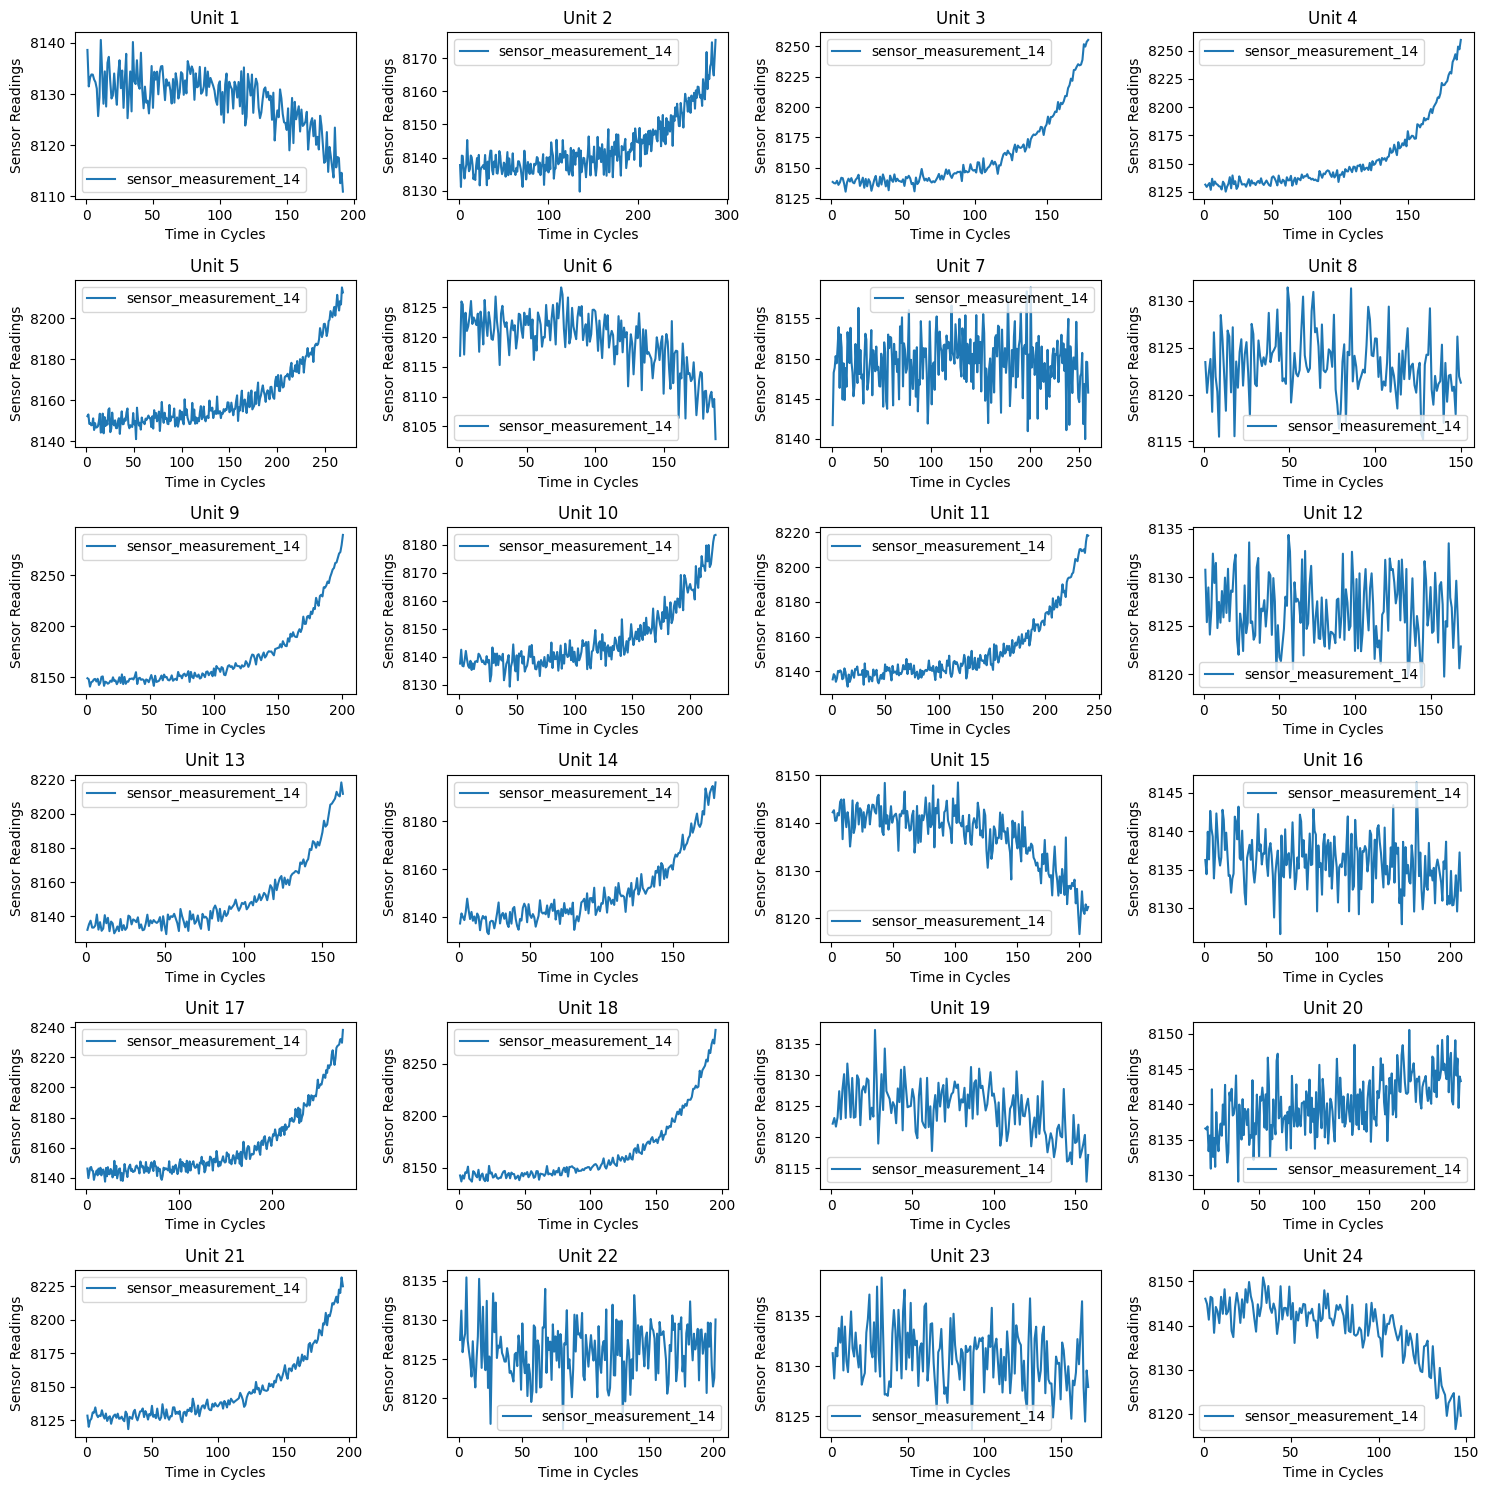

In [53]:
grid_plot_same_sensor_all_units_fig = grid_plot_same_sensor_all_units(df_train, sensor = 'sensor_measurement_14')
grid_plot_same_sensor_all_units_fig.show(block=False) 

## box plot

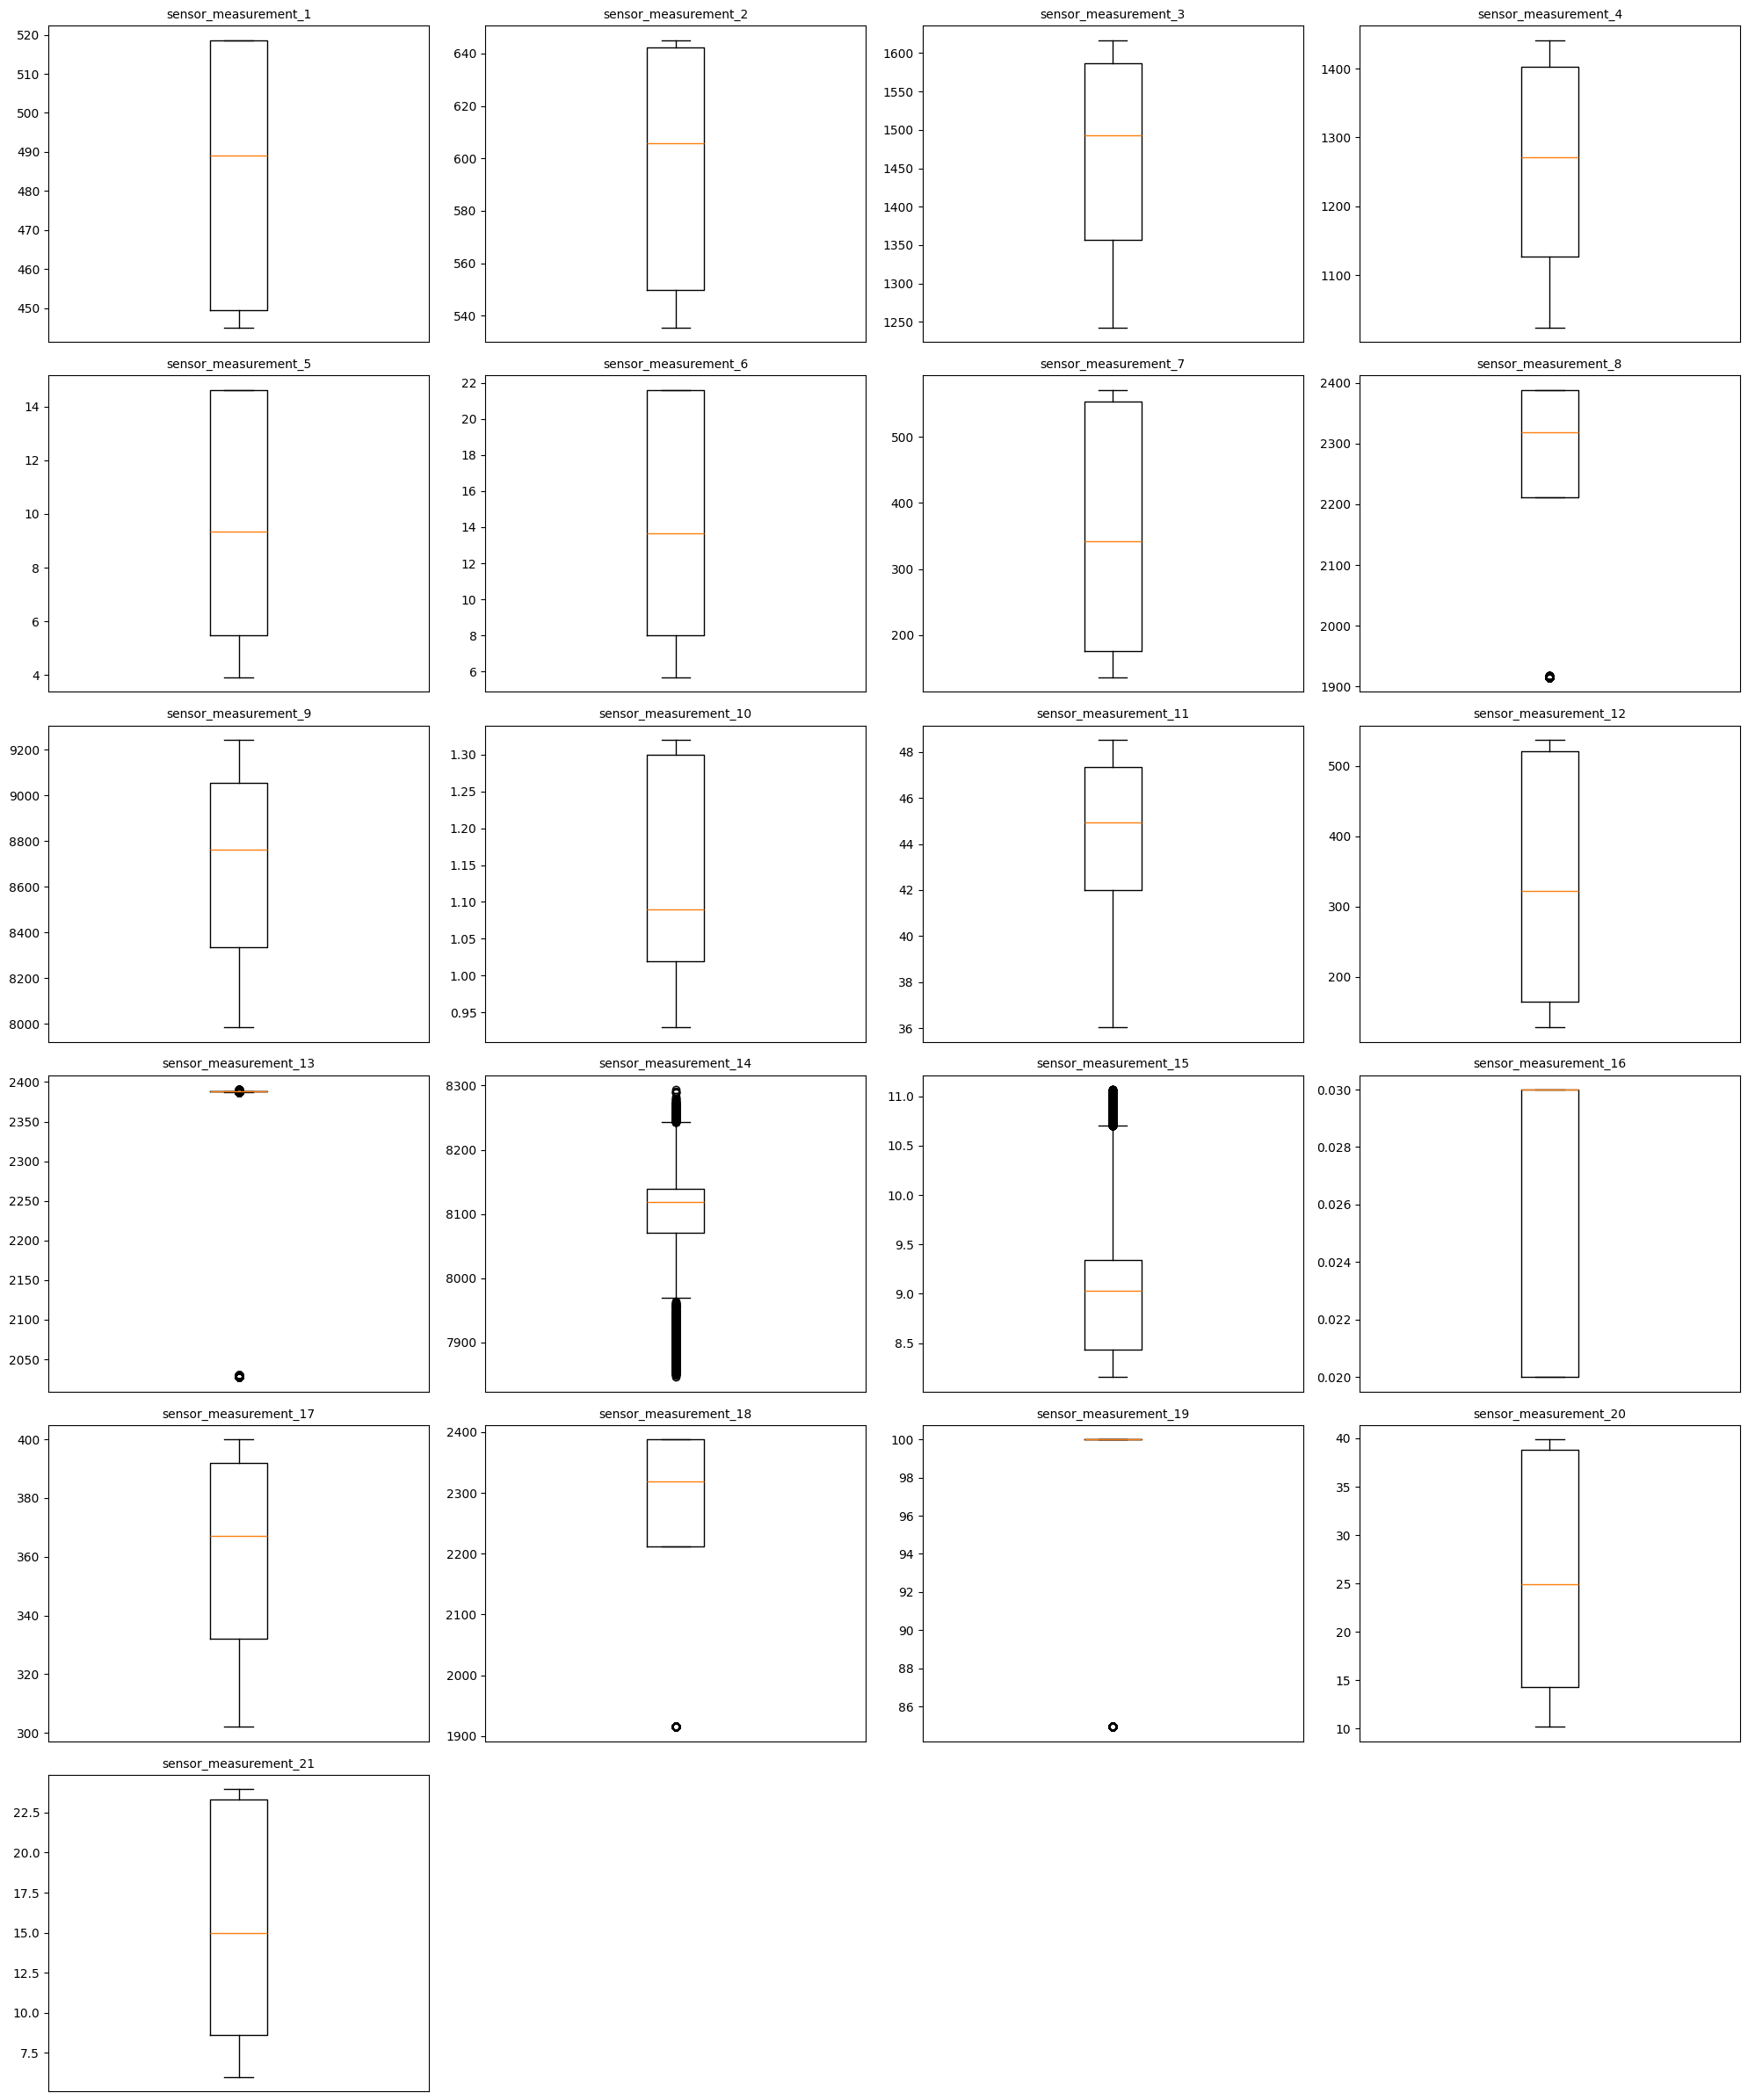

In [54]:
boxplot_figure = boxplot(df_train)
boxplot_figure.show(block=False) 

plt.show()  # Keeps all figures open

## auto correlation

<Figure size 800x500 with 0 Axes>

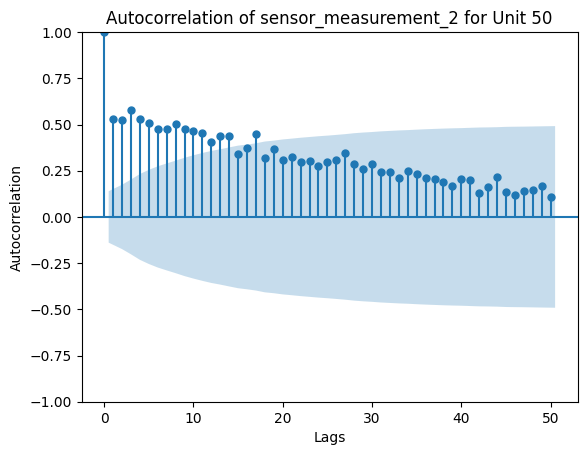

In [55]:
for sensor in [f"sensor_measurement_{x}" for x in range(2, 3)]:  # Adjust as needed
    no_grid_plot_raw_sensors_fig = auto_correlation(df_train,sensor, unit_id = 50)
    no_grid_plot_raw_sensors_fig.show(block=False)
plt.show() 

## distribution

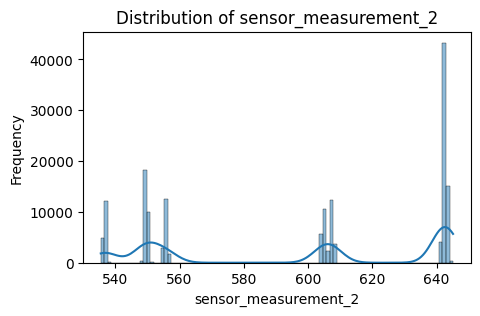

In [56]:
plt.figure(figsize=(5, 3))
sensor = 'sensor_measurement_2'
# df_unit = df_train[df_train["unit_number"] == 1] # use this if using all 4 engines
sns.histplot(df_train[sensor], bins=100, kde=True)
plt.title("Distribution of " + sensor)
plt.ylabel("Frequency")
plt.show()

# --> attention: I am reading in all 4 files --> all 4 "different" engines ! --> 4 peaks

## ADF test for stationary / non-stationary

In [57]:
from statsmodels.tsa.stattools import adfuller

# Select a sensor and drop NA values
sensor = "sensor_measurement_2"
unit_number = 1
df_unit = df_train[df_train["unit_number"] == unit_number] # for sure, this is based on individual data
time_series = df_unit[sensor].dropna()

# Perform ADF Test
adf_result = adfuller(time_series)

# Display results
print("ADF Test Results for:", sensor)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:", adf_result[4])

# Interpret results
if adf_result[1] < 0.05:
    print("Result: The data is stationary (reject H0).")
else:
    print("Result: The data is non-stationary (fail to reject H0).")

ADF Test Results for: sensor_measurement_2
ADF Statistic: 0.4020725466048467
p-value: 0.981572282048211
Critical Values: {'1%': -3.466598080268425, '5%': -2.8774669520682674, '10%': -2.5752604356654425}
Result: The data is non-stationary (fail to reject H0).


## linear vs non-linear

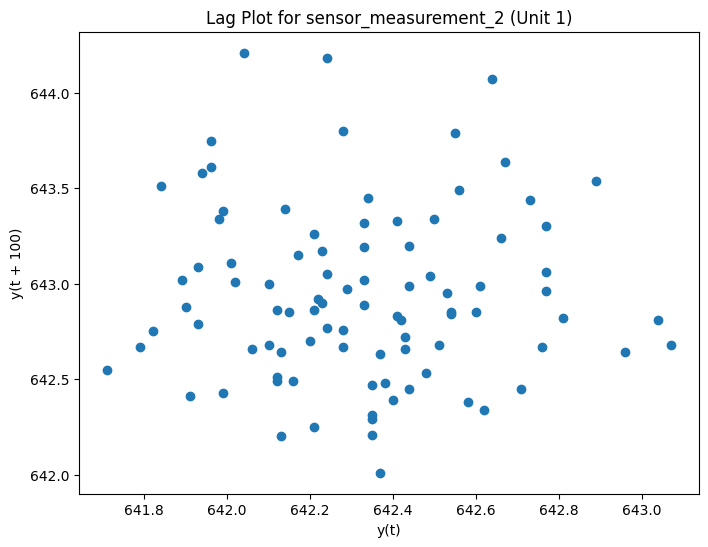

In [58]:
from pandas.plotting import lag_plot
import pandas as pd
# Plot lag correlation
sensor = "sensor_measurement_2"
unit_id = 1
df_unit = df_train[df_train["unit_number"] == unit_id] # for sure, this is based on individual data
plt.figure(figsize=(8, 6))
lag_plot(df_unit[sensor], lag = 100)
plt.title(f"Lag Plot for {sensor} (Unit {unit_id})")
plt.show()


## basic correlation matrix

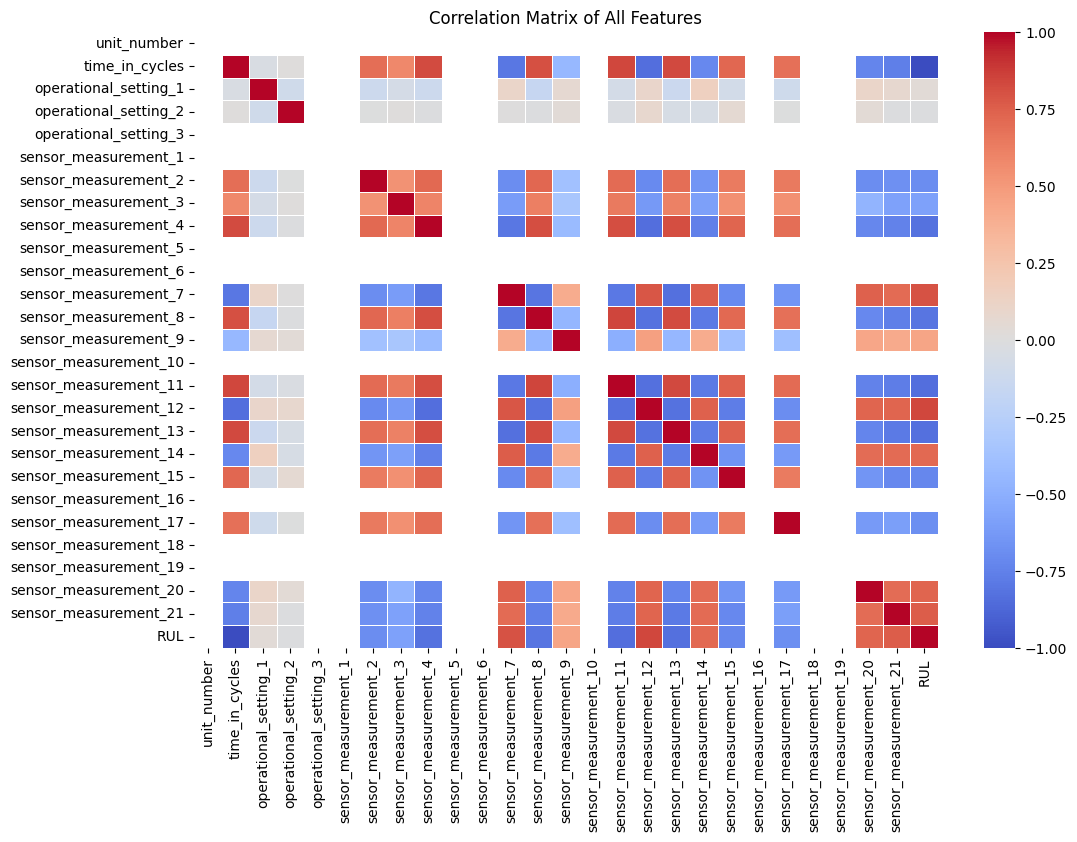

In [59]:
# df_unit = df_train[df_train["unit_number"] == unit_id] # for sure, this is based on individual data
corr_matrix =  df_train[df_train["unit_number"] == unit_id].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of All Features")
plt.show()

## PCA

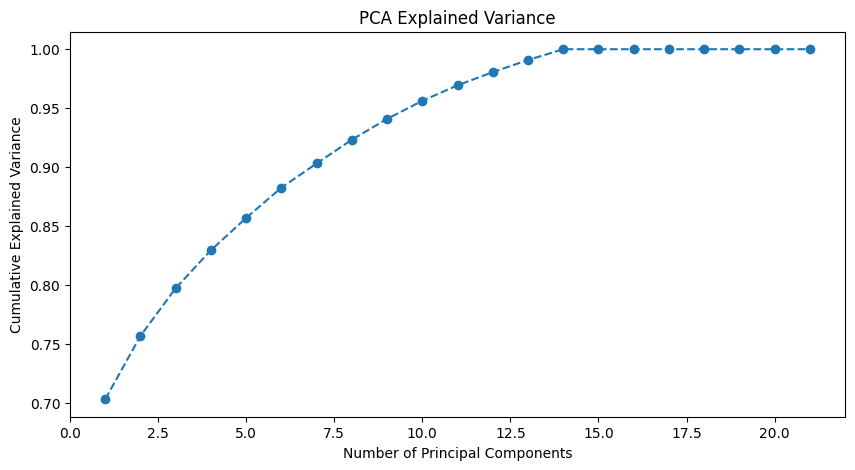

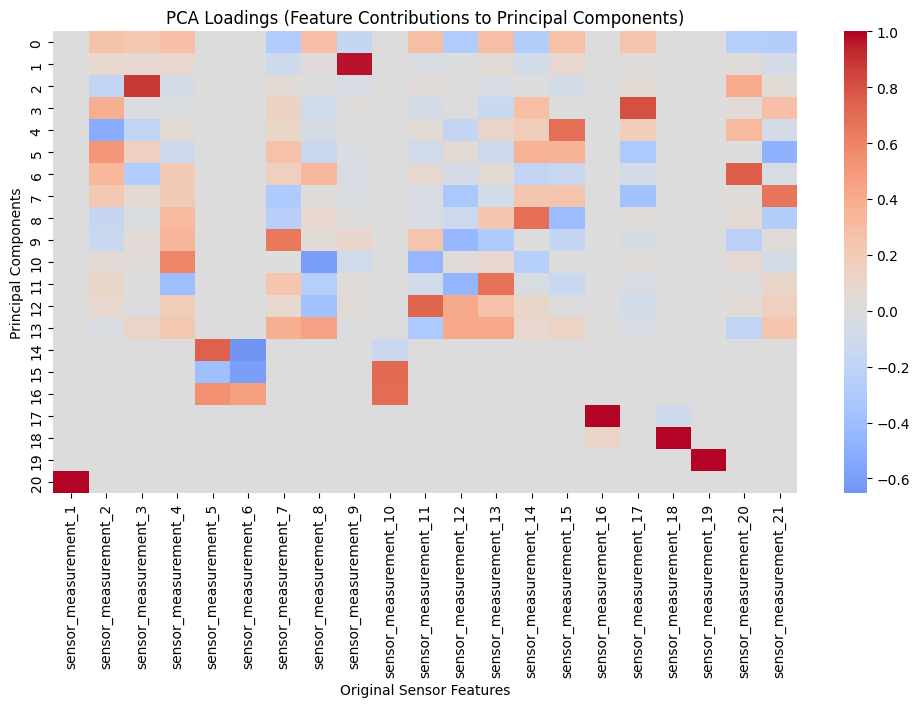

In [60]:

df_unit =  df_train[df_train["unit_number"] == unit_id]
# Select only sensor columns
sensor_cols = [col for col in df_train.columns if "sensor" in col]
sensor_data = df_unit[sensor_cols]

# Standardize the data
scaler = StandardScaler()
sensor_scaled = scaler.fit_transform(sensor_data)

# Apply PCA
pca = PCA(n_components=len(sensor_cols))  
pca.fit(sensor_scaled)

# Plot Explained Variance Ratio
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(sensor_cols)+1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()

# Create a DataFrame with PCA loadings
pca_components = pd.DataFrame(pca.components_, columns=sensor_cols)

# Plot heatmap of PCA loadings
plt.figure(figsize=(12, 6))
sns.heatmap(pca_components, cmap="coolwarm", center=0)
plt.xlabel("Original Sensor Features")
plt.ylabel("Principal Components")
plt.title("PCA Loadings (Feature Contributions to Principal Components)")
plt.show()